In [1]:
import cv2
import glob
import math
import pickle

import numpy             as np
import matplotlib.pyplot as plt

from sklearn.svm                import LinearSVC
from skimage.feature            import hog
from sklearn.model_selection    import train_test_split
from sklearn.metrics            import accuracy_score
from sklearn.preprocessing      import StandardScaler
from scipy.ndimage.measurements import label

from moviepy.editor             import VideoFileClip

In [2]:
def compute_spatial_feature(img, size=(32, 32)):
    '''
        Resize the image and flatten the data
    '''
    # Return the feature vector
    return cv2.resize(img, size).ravel()

In [3]:
def compute_color_histogram_feature(img, nbins=32, bins_range=(0, 255)):
    '''
        Compute the histogram of every channels ( must be 3 ) using
        nbins and bins_range to setup the histogram
        Then all 3 histograms are concatenated
    '''

    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))



In [4]:
# Define a function to return HOG features and visualization
def compute_hog_feature(img, norient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
        Return the HOG features and visualization if requested
    '''
    return hog(img, orientations=norient
                  , pixels_per_cell=(pix_per_cell, pix_per_cell)
                  , cells_per_block=(cell_per_block, cell_per_block)
                  , visualise=vis
                  , feature_vector=feature_vec
                  )


In [5]:
# Lookup for color conversion
CV2_COLOR_CONVERSION_FROM_RGB_TO = {
     'HSV'   : cv2.COLOR_RGB2HSV
    ,'LUV'   : cv2.COLOR_RGB2LUV
    ,'HLS'   : cv2.COLOR_RGB2HLS
    ,'YUV'   : cv2.COLOR_RGB2YUV
    ,'YCrCb' : cv2.COLOR_RGB2YCrCb
}

# Hash of our configuration of the different elment
# of the pipeline
configuration = {
     'color_space': 'YCrCb'
    ,'hog_parameters': {
                         'orient': 8
                        ,'pix_per_cell': 8
                        ,'cell_per_block': 4
                        ,'channel': 'all'
        
    }
    ,'color_histogram_parameters': {
                                     'nbins': 64
                                    ,'bin_range': (0,255)
    }
    ,'spatial_parameters': { 'size': (32,32) }
}

def extract_features(img, configuration=configuration):
    '''
        Extract the features from the image using the color space defined
        and the HOG feature , the color histogram and the spatial feature
        hog_channel can be 0 to n channel or 'all'. If 'all' they are concatenated
        in one feature vector
        
        Concatenate all features in one vector
    '''
    if configuration['color_space'] != 'RGB':
        feature_img = cv2.cvtColor(img, CV2_COLOR_CONVERSION_FROM_RGB_TO[configuration['color_space']])
    else:
        feature_img = np.copy(img)
    
    # To hold all our features
    features = []        
    
    # HOG feature
    hog_parameters = configuration['hog_parameters']
    if hog_parameters['channel'] == 'all':
        nchannel = feature_img.shape[2]

        for channel in range(nchannel):
            features.append( compute_hog_feature(feature_img[:,:,channel]  , hog_parameters['orient']
                                                                    , hog_parameters['pix_per_cell']
                                                                    , hog_parameters['cell_per_block']
                                                                    , False
                                                                    , False
                                                 ).ravel()
                           )
    else:
        features.append( compute_hog_feature(     feature_img[:,:,hog_parameters['channel']]
                                                , hog_parameters['orient']
                                                , hog_parameters['pix_per_cell']
                                                , hog_parameters['cell_per_block']
                                                , False
                                                , False
                                            ).ravel()
                       )
    # Histogram feature
    histo_parameters = configuration['color_histogram_parameters']
    features.append( compute_color_histogram_feature(feature_img, histo_parameters['nbins']
                                                                , histo_parameters['bin_range']
                                                    )
                       )

    # Saptial feature
    spatial_parameters = configuration['spatial_parameters']
    features.append( compute_spatial_feature(feature_img, spatial_parameters['size']) )
    
    # Concatenate all features
    return np.concatenate(features)

In [6]:
# Size of the image used to train our classifier
# Need to scale our extract to that size to make
# the classifier works
NPIX_CLASSIFIER = 64


def find_potential_cars_location(img, y_start, y_stop, window_size=64, config=configuration):
    '''
        Return a list of boxes where there is potentially a car
        
        config is a hash that must contains the below keys
        'SVC'    : SVC object used to classify feature as car (label 1) or not cars (label 0)
        'scaler' : A scale used to scale the feature
        'hog_parameters' : A hash of the hog param to use as defined below
            'orient'         : The number of orientation
            'pix_per_cell'   : The number of pixel per cell
            'cell_per_block' : The number of cell per block
    '''
    search_img = img[y_start:y_stop,:,:]
    
    if config['color_space'] != 'RGB':
        search_img = cv2.cvtColor(search_img, CV2_COLOR_CONVERSION_FROM_RGB_TO[config['color_space']])
    
    hog_param = config['hog_parameters']    
    
    npix_per_cell  = hog_param['pix_per_cell']
    npix_per_block = npix_per_cell * hog_param['cell_per_block']
    
    # Adjust the window size to keep it falling on cell boundary
    window_size = int((window_size / hog_param['pix_per_cell']) + 0.5) * hog_param['pix_per_cell']

    # The scale that we need to apply to extract our feature
    scale = window_size / NPIX_CLASSIFIER
    
    # Scale our image to subsample it
    if scale != 1.0:
        search_img = cv2.resize(search_img, (int(search_img.shape[1]/scale), int(search_img.shape[0]/scale)))
    
    # Define the search parameters
    wblock_size = ( (NPIX_CLASSIFIER - npix_per_block) // npix_per_cell ) + 1
    block_step  = 2
    
    # Extract the hog feature on the entire image for each channel
    hog1 = compute_hog_feature(search_img[:,:,0] , hog_param['orient']
                                                 , hog_param['pix_per_cell']
                                                 , hog_param['cell_per_block']
                                                 , feature_vec=False
                              )
    hog2 = compute_hog_feature(search_img[:,:,1] , hog_param['orient']
                                                 , hog_param['pix_per_cell']
                                                 , hog_param['cell_per_block']
                                                 , feature_vec=False
                              )
    hog3 = compute_hog_feature(search_img[:,:,2] , hog_param['orient']
                                                 , hog_param['pix_per_cell']
                                                 , hog_param['cell_per_block']
                                                 , feature_vec=False
                              )
    
    # Now extract info for every boxes
    max_yblock = len(hog1)    - wblock_size + 1
    max_xblock = len(hog1[0]) - wblock_size + 1
    bboxes = []
    for yblock in range(0, max_yblock, block_step):
        for xblock in range(0, max_xblock, block_step):
            # Compute the coordinate of the box
            xblock_right  = xblock + wblock_size
            yblock_bottom = yblock + wblock_size

            features = []
            # Extract the hog feature
            features.append( hog1[yblock:yblock_bottom, xblock:xblock_right].ravel() )
            features.append( hog2[yblock:yblock_bottom, xblock:xblock_right].ravel() )
            features.append( hog3[yblock:yblock_bottom, xblock:xblock_right].ravel() )

            # Extract the image patch
            xstart = xblock * npix_per_cell
            ystart = yblock * npix_per_cell
            sub_img = search_img[ystart:ystart+NPIX_CLASSIFIER,xstart:xstart+NPIX_CLASSIFIER]
            
            # Histogram feature
            histo_parameters = config['color_histogram_parameters']
            features.append( compute_color_histogram_feature(sub_img, histo_parameters['nbins']
                                                                    , histo_parameters['bin_range']
                                                    )
                           )
            
            # Saptial feature
            spatial_parameters = configuration['spatial_parameters']
            features.append( compute_spatial_feature(sub_img, spatial_parameters['size']) )

            allfeature = np.concatenate(features)
            
            # Apply the scaler to X
            scaled_X = config['scaler'].transform(allfeature.reshape(1, -1))

            # Classify our box
            pred = config['SVC'].predict(scaled_X)

            # If a car save the box
            if pred[0] == 1.0:
                #print((xblock,yblock,xblock_right,yblock_bottom))
                xstart = int(xblock * npix_per_cell * scale)
                ystart = int(yblock * npix_per_cell * scale) + y_start
                xend   = xstart + window_size
                yend   = ystart + window_size
                bboxes.append( ( (xstart, ystart) ,(xend  , yend) ) )
                        
    
    return bboxes
        

In [7]:
def add_heat(heatmap, bbox_list):
    '''
        Add += 1 for all pixels inside each bbox 
        Assuming each "box" takes the form ((x1, y1), (x2, y2))
    '''
    # Iterate through list of bboxes
    for bbox in bbox_list:
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1

    return heatmap
    

In [8]:
def draw_labeled_bboxes(img, labels):
    '''
        Draw rectangle defined by the labels
    '''
    draw_img = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image only if over 10 in size
        if (bbox[1][0] - bbox[0][0]) > 32 and (bbox[1][1] - bbox[0][1]) > 32:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_img

In [9]:
img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

WINDOWS = [
            { 'wsize': 128, 'ystart': img.shape[0] // 2, 'ystop': min(img.shape[0], (img.shape[0] // 2) + 3 * 128) }
           ,{ 'wsize': 96 , 'ystart': img.shape[0] // 2, 'ystop': min(img.shape[0], (img.shape[0] // 2) + 3 * 96)  }
           ,{ 'wsize': 64 , 'ystart': img.shape[0] // 2, 'ystop': min(img.shape[0], (img.shape[0] // 2) + 3 * 64)  }
]

# Number of histo data to keep
AVG_COUNT = 5

# Average heat map
avg_heat = []

def process_image(img):
    global iteration
    global avg_heat

    # Extract potential car location
    bboxes = []
    for win in WINDOWS:
        bboxes.extend(find_potential_cars_location(img, win['ystart']
                                                      , win['ystop']
                                                      , window_size=win['wsize']
                                                      , config=configuration))

    # Generate a heat map
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)

    # If 1st time, use current heat map as average
    if len(avg_heat) < 1:
        avg_heat = heat

    # Average the data
    avg_heat = ((avg_heat*(AVG_COUNT-1)) + heat) / AVG_COUNT
    
    # Apply threshold to help remove false positives
    avg_heat[avg_heat <= 2.0] = 0.0

    # Find final boxes from heatmap using label function
    labels = label(avg_heat)

    # Draw them
    return draw_labeled_bboxes(img, labels)

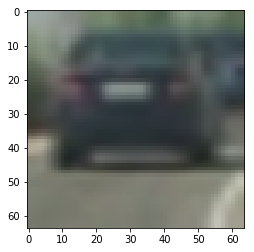

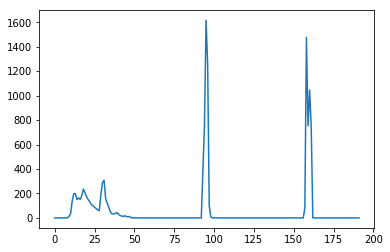

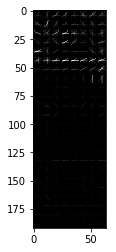

In [10]:
# Example of extraction
img = cv2.cvtColor(cv2.imread('./Trainings/vehicles/GTI_Far/image0001.png'), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

if configuration['color_space'] != 'RGB':
    feature_img = cv2.cvtColor(img, CV2_COLOR_CONVERSION_FROM_RGB_TO[configuration['color_space']])
else:
    feature_img = np.copy(img)

histo_parameters = configuration['color_histogram_parameters']
histo_feature = compute_color_histogram_feature(feature_img, histo_parameters['nbins']
                                                               , histo_parameters['bin_range']
                                                   )
plt.plot(histo_feature)
plt.show()


hog_parameters = configuration['hog_parameters']
hog_feature = []
nchannel = feature_img.shape[2]
features = []
visus = []
for channel in range(nchannel):
    feature, visu = compute_hog_feature(feature_img[:,:,channel]  , hog_parameters['orient']
                                                            , hog_parameters['pix_per_cell']
                                                            , hog_parameters['cell_per_block']
                                                            , True
                                                            , True)
    features.append(feature)
    visus.append(visu)
    
hog_feature = np.concatenate(features)
hog_visu = np.concatenate(visus)

plt.imshow(hog_visu, cmap='gray')
plt.show()



# Training

### 1 - Feature extraction

In [ ]:
cars_features = []
for filename in glob.glob('./Trainings/vehicles/*/*'):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    feature = extract_features(img)
    cars_features.append(feature)
        

In [ ]:
no_cars_features = []
for filename in glob.glob('./Trainings/non-vehicles/*/*'):    
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    feature = extract_features(img)
    no_cars_features.append(feature)


In [ ]:
print('n_cars={} - n_no_cars={}'.format(len(cars_features), len(no_cars_features)))

features = np.concatenate((cars_features, no_cars_features)).astype(np.float64)
labels = np.concatenate((np.ones(len(cars_features)), np.zeros(len(no_cars_features))))
del cars_features
del no_cars_features

### 2 - Normalization

In [ ]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(features)
# Keep it in our config
configuration['scaler'] = X_scaler
# Apply the scaler to X
scaled_X = X_scaler.transform(features)
    
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(132)
plt.plot(features[0])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[0])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

### 3 - Linear SVC training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels, test_size=0.2, random_state=42)

In [ ]:
clf = LinearSVC()

clf.fit(X_train, y_train)

# Keep it in our config
configuration['SVC'] = clf

In [ ]:
pred = clf.predict(X_test)
print('Model accuracy={:.4f}'.format(accuracy_score(y_test, pred)))

In [ ]:
del features
del scaled_X
del X_train
del X_test

In [ ]:
# Save our config
with open('./config.p', 'wb') as f:
    pickle.dump(configuration, f, pickle.HIGHEST_PROTOCOL)

In [11]:
# Import our config
configuration = pickle.load( open('./config.p', 'rb') )

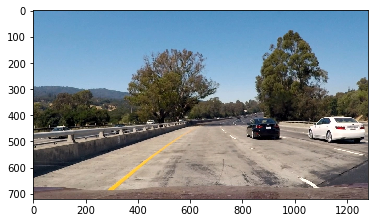

Extract potential cars location in 1.57s


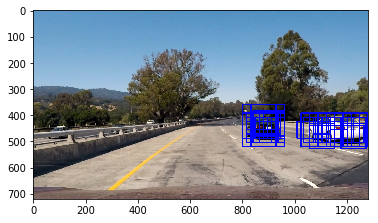

In [12]:
import time

img = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

windows = [
            { 'wsize': 128, 'ystart': img.shape[0] // 2, 'ystop': min(img.shape[0], (img.shape[0] // 2) + 3 * 128) }
           ,{ 'wsize': 96 , 'ystart': img.shape[0] // 2, 'ystop': min(img.shape[0], (img.shape[0] // 2) + 3 * 96)  }
           ,{ 'wsize': 64 , 'ystart': img.shape[0] // 2, 'ystop': min(img.shape[0], (img.shape[0] // 2) + 3 * 64)  }
]

t=time.time()
bboxes = []
for win in windows:
    bboxes.extend(find_potential_cars_location(img, win['ystart']
                                                  , win['ystop']
                                                  , window_size=win['wsize']
                                                  , config=configuration))
t2 = time.time()
print('Extract potential cars location in {:.2f}s'.format(t2-t))

draw_img = np.copy(img)
for bbox in bboxes:
    cv2.rectangle(draw_img, bbox[0]
                          , bbox[1]
                          , color=(0,0,255)
                          , thickness=4
                 )    

plt.imshow(draw_img)
plt.show()


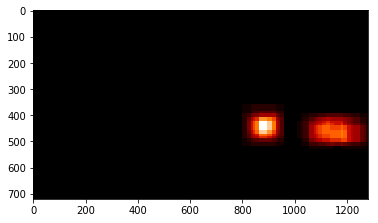

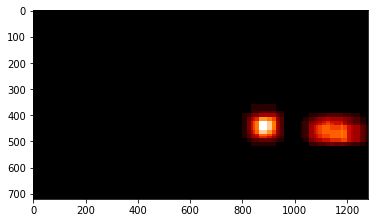

In [13]:
# Generate a heat map
heat = np.zeros_like(img[:,:,0]).astype(np.float)

heat = add_heat(heat, bboxes)

plt.imshow(heat, cmap='gist_heat')
plt.show()

# Apply threshold to help remove false positives
heat[heat <= 1.0] = 0.0

plt.imshow(heat, cmap='gist_heat')
plt.show()


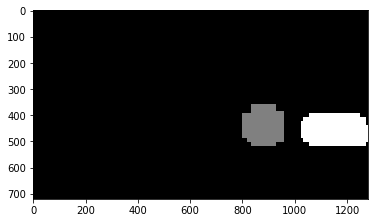

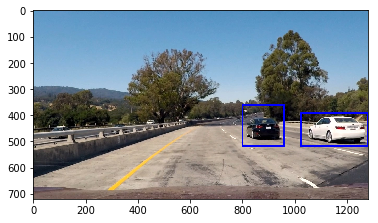

In [14]:
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.imshow(labels[0], cmap='gray')
plt.show()

draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.imshow(draw_img)
plt.show()

In [ ]:
video_output = 'test_video_out.mp4'
clip1 = VideoFileClip("./test_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)